https://forecastegy.com/posts/multi-step-time-series-forecasting-in-python/

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.ensemble import RandomForestRegressor

In [2]:

class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None, target_col=None) -> None:
        self.datainput = datainput
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler
        self.target_col = target_col
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self) -> pd.DataFrame:
        if self.normalize_bool:
            data = self.scaler.fit_transform(self.datainput)
            return pd.DataFrame(data, columns=self.datainput.columns)
        else:
            return self.datainput

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1 - self.test_size))
            train = data.iloc[:train_idx]
            test = data.iloc[train_idx:]
            return train, test
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs.
        """
        samples = data.shape[0] // self.timestep
        if samples <= 0:
            raise ValueError(
                "The number of samples is less than or equal to 0. Ensure data length is greater than timestep.")
        result = np.array_split(data[:samples * self.timestep], samples)
        return np.array(result)

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0:
            train = train[:-(train_remainder)]
        if test_remainder != 0:
            test = test[:-(test_remainder)]
        # print("train:", train, "test:", test)
        if len(train) < self.timestep or len(test) < self.timestep:
            raise ValueError(
                "Not enough data to form at least one timestep window.")
        train_transformed, test_transformed = self.window_and_reshape(
            train), self.window_and_reshape(test)
        print(f'train_transformed shape: {train_transformed.shape}')
        print(f'test_transformed shape: {test_transformed.shape}')
        return train_transformed, test_transformed

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        print("train:", train, "test:", test)
        return self.transform(train, test)

    def to_supervised(self, data, n_out=5) -> tuple:
        X, y = [], []
        for sample in data:
            if len(sample) >= self.n_input + n_out:
                for i in range(len(sample) - self.n_input - n_out + 1):
                    X.append(sample[i:i + self.n_input])
                    y.append(sample[i + self.n_input:i +
                             self.n_input + n_out, :])
        print(len(sample) - self.n_input - n_out + 1)
        X, y = np.array(X), np.array(y)
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    attention_output, _ = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x, return_attention_scores=True)
    x = layers.Dropout(dropout)(attention_output)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    n_timesteps, n_features, n_outputs = 5, 3, 15
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    masked_inputs = layers.Masking()(inputs)
    # x = inputs
    x = masked_inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_outputs)(x)
    outputs = layers.Reshape((n_timesteps, n_features))(outputs)
    return tf.keras.Model(inputs, outputs)


def build_custom_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    n_timesteps, n_features, n_outputs = 5, 1, 1  # Adjust based on your data
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))

    # Split inputs for each feature
    inputs_split = [inputs[:, :, i:i+1] for i in range(n_features)]

    # Create separate transformer encoders for each feature
    encoded_features = []
    for input_feature in inputs_split:
        x = input_feature
        for _ in range(num_trans_blocks):
            x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                    dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)
        encoded_features.append(x)

    # Concatenate the encoded features
    concatenated = layers.Concatenate(axis=-1)(encoded_features)
    x = layers.GlobalAveragePooling1D(
        data_format="channels_first")(concatenated)

    # Fully connected layers
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_outputs)(x)

    return tf.keras.Model(inputs, outputs)


def fit_transformer(transformer, x_train, y_train, x_val, y_val, display_loss=False):
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape']
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)]

    hist = transformer.fit(x_train, y_train,
                           validation_data=(x_val, y_val),
                           batch_size=32, epochs=25,
                           verbose=1, callbacks=callbacks)

    if display_loss:
        history_df = pd.DataFrame(hist.history)
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()

        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

    return hist

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class PredictAndForecast:
    def __init__(self, model, train, test, n_input=30, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        # self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]

        input_x = input_x.reshape((1, self.n_input, input_x.shape[1]))

        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)

        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self, step) -> np.array:
        """
        Compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]

        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            predictions.append(yhat_sequence)
            history.append(self.test[i, :])
        if step > len(self.test):
            for _ in range(step - len(self.test)):
                yhat_sequence = self.forecast(history)
                predictions.append(yhat_sequence)
                history.append(yhat_sequence)

        predictions = np.array(predictions)
        print(f"Predictions shape: {predictions.shape}")
        return predictions

    def recursive_predict(self, steps: int) -> pd.Series:
        print("************************")
        train_series = pd.Series(self.train.flatten())
        test_series = pd.Series(self.test.flatten())
        print(f"Initial training series:\n{train_series}\n")
        print(f"train value {train_series}")
        print(f"origin value {test_series}")
        print("***********************")
        forecaster = ForecasterAutoreg(
            regressor=LinearRegression(), lags=self.n_input)

        predictions = []
        history = train_series.copy()
        # history = list(train_series)
        forecaster.fit(y=train_series)

        for step in range(steps):
            # forecaster.fit(y=pd.Series(history))
            next_prediction = forecaster.predict(steps=1)
            predicted_value = next_prediction.values[0]
            original_value = test_series[step] if step < len(
                test_series) else None

            print(f"Step {step + 1}:")
            print(f"Predicted value: {predicted_value}")
            print(f"Original value: {original_value}")
            print(f"next prediction:{next_prediction}")

            if original_value is not None:
                if original_value == 0:
                    predictions.append(predicted_value)
                    print(f"Prediction reality.{predicted_value}")
                elif abs(predicted_value - original_value) <= 0.05:
                    predictions.append(predicted_value)
                    print("Prediction within tolerance.")
                else:
                    adjusted_prediction = (
                        predicted_value + original_value) / 2
                    predictions.append(adjusted_prediction)
                    print(f"Adjusted prediction: {adjusted_prediction}")
            else:
                predictions.append(predicted_value)
                print("No original value to compare. Using predicted value.")
            
            # history = pd.concat(
            #     [history, pd.Series([predicted_value], index=[history.index[-1] + 1])])

        prediction_series = pd.Series(predictions, index=pd.date_range(
            start=history.index[-steps], periods=steps, freq='D'))
        # prediction_dates = pd.date_range(
        #     start=len(test_series), periods=steps, freq='D')
        # prediction_series = pd.Series(predictions, index=prediction_dates)

        print(f"Final prediction series:\n{prediction_series}\n")
        return prediction_series

    def direct_predict(self, steps: int) -> pd.Series:
        # train_series = pd.Series(self.train.flatten(), index=pd.date_range(
        #     start='2000', periods=len(self.train.flatten())))
        train_series = pd.Series(self.train.flatten())
        test_series = pd.Series(self.test.flatten())

        max_steps = min(steps, len(train_series) - self.n_input)

        forecaster = ForecasterAutoregDirect(
            regressor=LinearRegression(), lags=self.n_input, steps=max_steps)
        forecaster.fit(y=train_series)
        predictions = forecaster.predict()
        prediction_series = pd.Series(predictions.values, index=pd.date_range(
            start=train_series.index[-1], periods=max_steps + 1, freq='D')[1:])
        return prediction_series

    def plot_predictions(self, steps: int, preds, normaliza_bool, scaler) -> None:
        recursive_prediction_series = self.recursive_predict(steps)
        direct_prediction_series = self.direct_predict(steps)

        # Ensure both predictions have the same length
        min_steps = min(len(recursive_prediction_series),
                        len(direct_prediction_series))
        recursive_prediction_series = recursive_prediction_series[:min_steps]
        direct_prediction_series = direct_prediction_series[:min_steps]

        plot_preds = preds[:min_steps]
        # Flatten self.train for plotting
        train_series = self.train.reshape(-1, 3)
        test_series = self.test.reshape(-1, 3)

        if normaliza_bool:
            reshaped_recursive = np.repeat(
                recursive_prediction_series.values.reshape(-1, 1), 3, axis=1)
            reshaped_direct = np.repeat(
                direct_prediction_series.values.reshape(-1, 1), 3, axis=1)
            reshaped_preds = np.repeat(plot_preds.reshape(-1, 1), 3, axis=1)

            inverse_recursive = scaler.inverse_transform(reshaped_recursive)[
                :, 0]
            inverse_direct = scaler.inverse_transform(reshaped_direct)[:, 0]
            inverse_preds = scaler.inverse_transform(reshaped_preds)[:, 0]

            recursive_prediction_series = pd.Series(
                inverse_recursive, index=recursive_prediction_series.index)
            direct_prediction_series = pd.Series(
                inverse_direct, index=direct_prediction_series.index)
            plot_preds = inverse_preds

            train_series = scaler.inverse_transform(train_series).flatten()
            test_series = scaler.inverse_transform(test_series).flatten()

        plt.figure(figsize=(10, 6))
        # Plot the training data
        plt.plot(range(len(train_series)), train_series, label='Training Data')

        # Plot the test data
        test_start_index = len(train_series)
        plt.plot(range(test_start_index, test_start_index +
                 len(test_series)), test_series, label='Origin Data', color='black')

        # Adjust prediction indices to align with the start of the test data
        prediction_start_index = test_start_index
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), plot_preds,
                 label='Hybrid Predictions', linestyle='--', color='green')
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), recursive_prediction_series,
                 label='Recursive Predictions', color='red')
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), direct_prediction_series,
                 label='Direct Predictions', color='purple')

        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.title('Recursive vs Direct Predictions')
        plt.legend()
        plt.show()
        return test_series[:min_steps], recursive_prediction_series, direct_prediction_series, plot_preds

    def evaluate_predictions(self, test_series, recursive_preds, direct_preds, hybrid_preds):
        metrics = {
            'recursive': {
                'MAE': mean_absolute_error(test_series, recursive_preds),
                'MAPE': mean_absolute_percentage_error(test_series, recursive_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, recursive_preds)),
                'R2': r2_score(test_series, recursive_preds)
            },
            'direct': {
                'MAE': mean_absolute_error(test_series, direct_preds),
                'MAPE': mean_absolute_percentage_error(test_series, direct_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, direct_preds)),
                'R2': r2_score(test_series, direct_preds)
            },
            'hybrid': {
                'MAE': mean_absolute_error(test_series, hybrid_preds),
                'MAPE': mean_absolute_percentage_error(test_series, hybrid_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, hybrid_preds)),
                'R2': r2_score(test_series, hybrid_preds)
            }
        }
        print("Evaluation Metrics:")
        print("\nRecursive Predictions:")
        print(f"MAE: {metrics['recursive']['MAE']}")
        print(f"MAPE: {metrics['recursive']['MAPE']}")
        print(f"RMSE: {metrics['recursive']['RMSE']}")
        print(f"R2: {metrics['recursive']['R2']}")

        print("\nDirect Predictions:")
        print(f"MAE: {metrics['direct']['MAE']}")
        print(f"MAPE: {metrics['direct']['MAPE']}")
        print(f"RMSE: {metrics['direct']['RMSE']}")
        print(f"R2: {metrics['direct']['R2']}")

        print("\nHybrid Predictions:")
        print(f"MAE: {metrics['hybrid']['MAE']}")
        print(f"MAPE: {metrics['hybrid']['MAPE']}")
        print(f"RMSE: {metrics['hybrid']['RMSE']}")
        print(f"R2: {metrics['hybrid']['R2']}")
        return metrics

In [5]:
def calculate_TEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = (3 * ema1) - (3 * ema2) + ema3
    return tema.dropna()


def calculate_DEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


ticker = '^GSPC'
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

data1 = calculate_DEMA(dataset['Close'], 10)
data2 = calculate_TEMA(dataset['Close'], 10)


dataset_input = pd.DataFrame({
    'Close': dataset['Close'],
    'DEMA': data1,
    'TEMA': data2
})
print(dataset_input)

[*********************100%%**********************]  1 of 1 completed

                  Close         DEMA         TEMA
Date                                             
1990-01-02   359.690002   359.690002   359.690002
1990-01-03   358.760010   359.382567   359.269375
1990-01-04   355.670013   358.134696   357.593960
1990-01-05   352.200012   356.070760   354.924567
1990-01-08   353.790009   355.086776   353.913206
...                 ...          ...          ...
2024-08-01  5446.680176  5456.648572  5444.475293
2024-08-02  5346.560059  5416.142546  5393.531229
2024-08-05  5186.330078  5333.758106  5288.452841
2024-08-06  5240.029785  5291.486507  5245.062796
2024-08-07  5199.500000  5248.089665  5201.272144

[8716 rows x 3 columns]


In [6]:
scaler_type = StandardScaler()
# Prepare the ETL instance
data = ETL(
    datainput=dataset_input,
    test_size=0.1,
    n_input=5,  # Look-back period
    timestep=10,  # Number of past days to use for each prediction
    normalize_bool=True,
    scaler=scaler_type
)

X_train, y_train = data.X_train, data.y_train
X_val, y_val = data.X_test, data.y_test
print(f"X_train shape: {data.X_train.shape}")
print(f"X_test shape: {data.X_test.shape}")
print(f"y_train shape: {data.y_train.shape}")
print(f"y_test shape: {data.y_test.shape}")

train:          Close      DEMA      TEMA
0    -1.091944 -1.091725 -1.091823
1    -1.092733 -1.091986 -1.092180
2    -1.095356 -1.093045 -1.093602
3    -1.098301 -1.094796 -1.095867
4    -1.096951 -1.095631 -1.096725
...        ...       ...       ...
7839  1.926539  1.923138  1.934044
7840  1.942197  1.934103  1.944449
7841  1.940296  1.941066  1.949342
7842  1.939226  1.945332  1.950944
7843  1.924493  1.943099  1.944259

[7844 rows x 3 columns] test:          Close      DEMA      TEMA
7844  1.918332  1.938936  1.936090
7845  1.892693  1.926979  1.918367
7846  1.896827  1.919190  1.908029
7847  1.934219  1.925579  1.917969
7848  1.852670  1.903172  1.887715
...        ...       ...       ...
8711  3.225270  3.232912  3.222961
8712  3.140300  3.198543  3.179732
8713  3.004317  3.128642  3.090566
8714  3.049890  3.092776  3.053746
8715  3.015494  3.055955  3.016587

[872 rows x 3 columns]
train_transformed shape: (784, 10, 3)
test_transformed shape: (87, 10, 3)
1
X shape: (784, 5, 3)
y

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
data.train

array([[[-1.09194414, -1.09172535, -1.0918234 ],
        [-1.0927334 , -1.0919862 , -1.09218033],
        [-1.09535581, -1.09304499, -1.09360203],
        ...,
        [-1.10141538, -1.10036254, -1.10194082],
        [-1.10871402, -1.10349989, -1.10571718],
        [-1.11120063, -1.10658694, -1.1092178 ]],

       [[-1.10801809, -1.10774677, -1.10992641],
        [-1.11086117, -1.10946444, -1.11147948],
        [-1.11019071, -1.11043148, -1.11201408],
        ...,
        [-1.1204682 , -1.11853321, -1.11978311],
        [-1.12070583, -1.12009753, -1.12120829],
        [-1.12121502, -1.12132565, -1.12219181]],

       [[-1.12309908, -1.12275934, -1.12350723],
        [-1.11792217, -1.12201187, -1.12185757],
        [-1.11816827, -1.12145019, -1.12070461],
        ...,
        [-1.1146293 , -1.11674105, -1.11459051],
        [-1.11406917, -1.11592085, -1.1138021 ],
        [-1.11707349, -1.1162961 , -1.11468142]],

       ...,

       [[ 1.77009346,  1.76694648,  1.76648291],
        [ 1

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy th

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.6571 - mae: 0.6538 - mape: 169.9601 - val_loss: 3.2924 - val_mae: 1.7453 - val_mape: 74.6600
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2973 - mae: 0.4327 - mape: 144.6645 - val_loss: 2.0746 - val_mae: 1.3942 - val_mape: 59.6300
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1648 - mae: 0.3221 - mape: 97.3674 - val_loss: 0.8794 - val_mae: 0.8780 - val_mape: 37.4783
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1304 - mae: 0.2818 - mape: 150.9784 - val_loss: 0.2808 - val_mae: 0.4706 - val_mape: 20.0098
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0973 - mae: 0.2450 - mape: 103.1089 - val_loss: 0.3035 - val_mae: 0.5146 - val_mape: 22.0293
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0970 - mae: 0.2442 - mape: 126.8990 - val_loss: 0.4048 - val_mae: 0.5865 - val_mape: 25.3340
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1007 - mae: 0.2544 - mape:

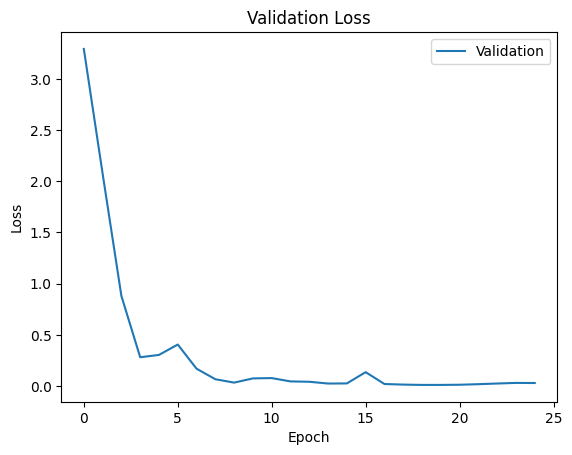

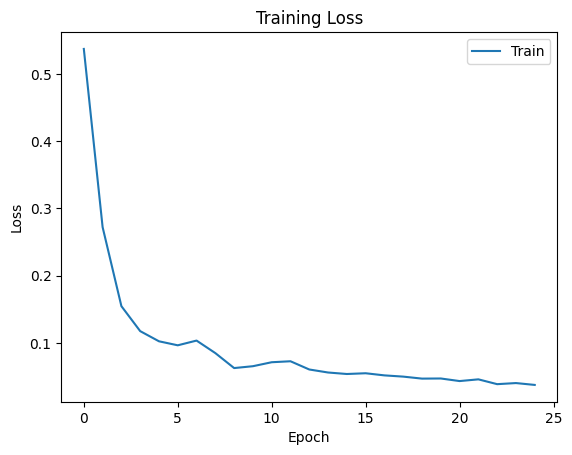

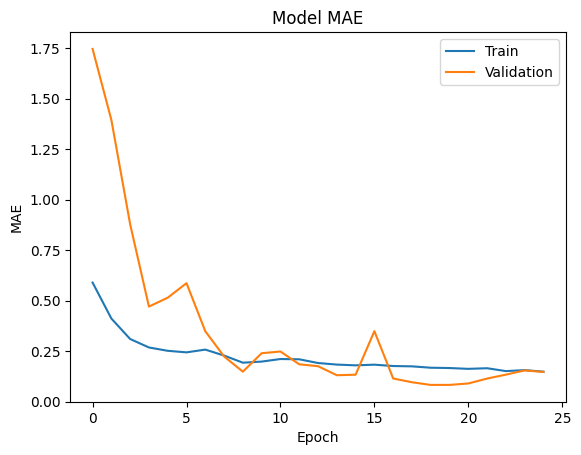

In [8]:
model = build_transformer(head_size=16, num_heads=4,
                          ff_dim=128, num_trans_blocks=12,
                          mlp_units=[64],
                          dropout=0.2, mlp_dropout=0.2)
fit_transformer(model, X_train, y_train, X_val, y_val, display_loss=True)

Predictions shape: (1700, 5, 3)
Predictions shape: (1700, 5, 3)
************************
Initial training series:
0       -1.091944
1       -1.091725
2       -1.091823
3       -1.092733
4       -1.091986
           ...   
11755    1.831893
11756    1.827899
11757    1.888654
11758    1.851067
11759    1.854586
Length: 11760, dtype: float64

train value 0       -1.091944
1       -1.091725
2       -1.091823
3       -1.092733
4       -1.091986
           ...   
11755    1.831893
11756    1.827899
11757    1.888654
11758    1.851067
11759    1.854586
Length: 11760, dtype: float64
origin value 0       1.918332
1       1.938936
2       1.936090
3       1.892693
4       1.926979
          ...   
1300    3.243575
1301    3.211303
1302    3.239579
1303    3.237523
1304    3.211411
Length: 1305, dtype: float64
***********************
Step 1:
Predicted value: 1.8747011485255058
Original value: 1.9183318907921563
next prediction:11760    1.874701
Name: pred, dtype: float64
Prediction within tolera

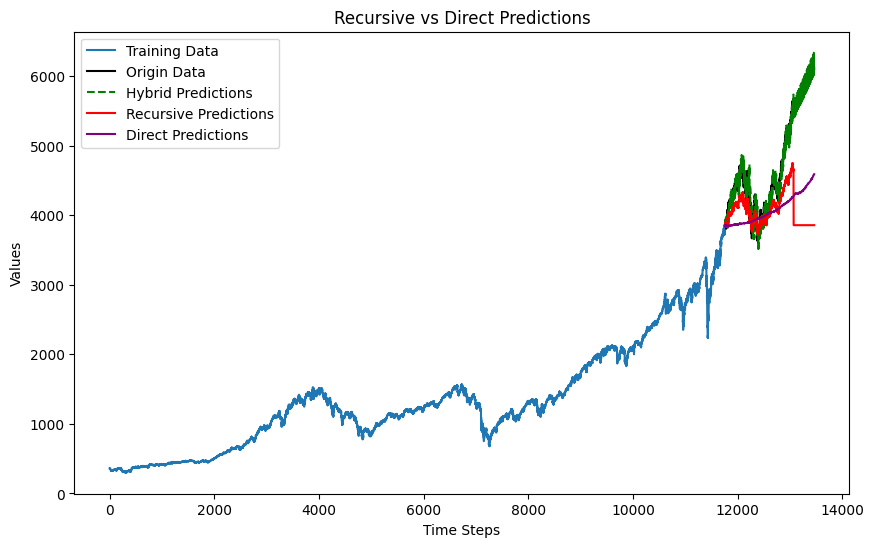

In [27]:
# scaler = StandardScaler()
# train_data = scaler.fit_transform(
#     X_train.reshape(-1, 1)).reshape(X_train.shape)

predict_and_forecast = PredictAndForecast(
    model, X_train, X_val,
    n_input=5, scaler=None,
    normalize_bool=False
)
step_time_prediction = 1700

predictions = predict_and_forecast.get_predictions(step=step_time_prediction)
print(f'Predictions shape: {predictions.shape}')
predictions = np.array(predictions).flatten()
# predict_and_forecast.plot_predictions(
#     steps=500, preds=predictions, normaliza_bool=True, scaler=scaler_type)
test_series, recursive_preds, direct_preds, hybrid_preds = predict_and_forecast.plot_predictions(
    steps=step_time_prediction, preds=predictions, normaliza_bool=True, scaler=scaler_type)

In [20]:
metrics = predict_and_forecast.evaluate_predictions(
    test_series, recursive_preds, direct_preds, hybrid_preds)
print(metrics)

Evaluation Metrics:

Recursive Predictions:
MAE: 277.10695281926803
MAPE: 0.05922322395143965
RMSE: 347.87206124312206
R2: 0.38374654625604687

Direct Predictions:
MAE: 347.1644344011914
MAPE: 0.07554524143146041
RMSE: 432.4251618980707
R2: 0.04776930101506227

Hybrid Predictions:
MAE: 116.4023963799303
MAPE: 0.026996516714397557
RMSE: 148.26920708058722
R2: 0.8880504904495459
{'recursive': {'MAE': 277.10695281926803, 'MAPE': 0.05922322395143965, 'RMSE': 347.87206124312206, 'R2': 0.38374654625604687}, 'direct': {'MAE': 347.1644344011914, 'MAPE': 0.07554524143146041, 'RMSE': 432.4251618980707, 'R2': 0.04776930101506227}, 'hybrid': {'MAE': 116.4023963799303, 'MAPE': 0.026996516714397557, 'RMSE': 148.26920708058722, 'R2': 0.8880504904495459}}


In [ ]:
predict_and_forecast.evaluate_predictions(
    steps=600, preds=predictions, normaliza_bool=True, scaler=scaler_type)

TypeError: PredictAndForecast.evaluate_predictions() got an unexpected keyword argument 'steps'

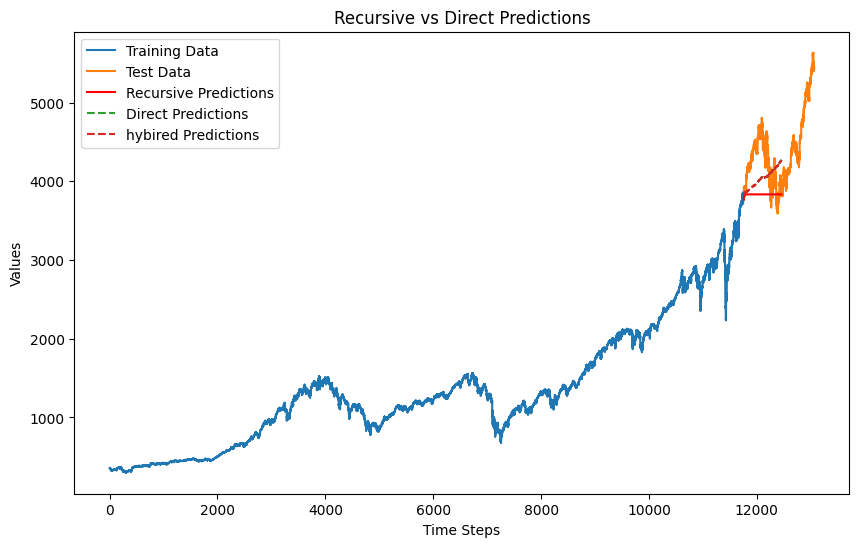

In [ ]:
predict_and_forecast.plot_predictions(steps=700, preds=predictions)

In [ ]:
predict_and_forecast.evaluate_predictions(steps=700)

Recursive MAE: 184.33419319718936
Recursive RMSE: 225.3724821301237
Recursive R2: -1.0961695730481695
Recursive MAPE: 0.037489060137923164
Direct MAE: 154.07138010071267
Direct RMSE: 192.74002184232185
Direct R2: -1.0961695730481695
Direct MAPE: 0.037489060137923164


In [ ]:
from tensorflow.keras import layers, models, optimizers, losses


def train_transformer(model, x_train, y_train, x_val, y_val, epochs=50, batch_size=32):
    optimizer = optimizers.Adam(learning_rate=1e-4)
    loss_fn = losses.MeanSquaredError()

    train_dataset = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (x_val, y_val)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Training loop
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch_train, training=True)
                loss = loss_fn(y_batch_train, predictions)

            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            if step % 100 == 0:
                print(f"Training loss at step {step}: {loss.numpy()}")

        # Validation loop
        val_loss = []
        for x_batch_val, y_batch_val in val_dataset:
            val_predictions = model(x_batch_val, training=False)
            val_loss.append(loss_fn(y_batch_val, val_predictions).numpy())

        print(f"Validation loss: {np.mean(val_loss)}")


def plot_results(train, test, preds, df, normalize_bool, scaler, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    if normalize_bool == True:
        # Inverse transform to get back to original scale
        plot_test = scaler.inverse_transform(
            plot_test.reshape(-1, 1)).reshape(plot_test.shape)
        train = scaler.inverse_transform(
            train.reshape(-1, 1)).reshape(train.shape)
        plot_preds = scaler.inverse_transform(
            plot_preds.reshape(-1, 1)).reshape(plot_preds.shape)
        print("normalization convert active")

    # x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_train = train.reshape((train.shape[0]*train.shape[1], 1))
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    x_train = df[:len(plot_train)].index
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()


train_transformer(model, X_train, y_train, X_val, y_val)

NameError: name 'model' is not defined